Goal
- Find the smallest eigenvector $\lambda$ for the NC node

Problem
- Some methods too slow and/or crash on certain cases
---
Input
 - Positive definite matrix (symmetric)

Output
 - Graph cut of the matrix (corresponds to the smallest eigenvector)
---
Must
- Handle image sized inputs
- Have reproducible results (fixed seed)

In [43]:
import numpy as np
from scipy import linalg
import torch

import cv2
import sys
sys.path.append("..")
from nc_suite import *

seed = 123
dtype = np.float64 # Currently doesn't do anything as random.rand doesn't accept
n = 28
# and possibly generate different sparisities?? As realistically will be somewhat sparse
np.random.seed(seed)


img_baby = cv2.imread("../data/test/3.jpg",0)
img_baby = cv2.resize(img_baby, (28,28))

A = intens_posit_wm(img_baby)

In [44]:
# used to store each of the functions, and allow them to all take the single arg input
from collections import OrderedDict
from functools import partial

# scipy and numpy are used for the eigensolvers
import scipy.linalg as linalg
import scipy.sparse.linalg as sparse

eigs_options = OrderedDict(
    # Numpy (no params only inputs)
    np_eig = np.linalg.eig,
    np_eigh = np.linalg.eigh, # Should be good
    
    # Some parameters for scipy variants
    sp_eig = partial(linalg.eig, check_finite=False), # No extra params

    sp_eigh_base = partial(linalg.eigh), # Should be good (and all variations might improve for the single eigenvector case)
    sp_eigh_cff = partial(linalg.eigh, check_finite=False),
    # Subset by index only for evr, evx, and gvx
    # Subsetting (0,1] so that [1] gives the second smallest (so indexing is the same as others which return all vectors)
    # [1,1] will give just the second smallest
    # sp_eigh_ss = partial(linalg.eigh, check_finite=False, subset_by_index=[0,1]), # driver=, type=(generalized or not), 
    
    sp_eigh_ev_ss = partial(linalg.eigh, check_finite=False, driver='ev'), # symmetric qr, slow but robust
    # sp_eigh_evd = partial(linalg.eigh, check_finite=False, driver='evd'), # uses more memory but faster
    # sp_eigh_evr_ss = partial(linalg.eigh, check_finite=False, subset_by_index=[0,1], driver='evr'), # optimal for most
    # sp_eigh_evx_ss = partial(linalg.eigh, check_finite=False, subset_by_index=[0,1], driver='evx'), # subsets
    
    # uses D for the generalized problem
    # sp_eigh_gv = partial(linalg.eigh, check_finite=False, driver='gv', b=D),
    # sp_eigh_gvd = partial(linalg.eigh, check_finite=False, driver='gvd', b=D),
    # sp_eigh_gvx_ss = partial(linalg.eigh, check_finite=False, subset_by_index=[0,1], driver='gvx', b=D),
    
    # LOBPCG would be nice to test
)

# NOTE: lots of extra info in eigs-test (this is eigs-test2)
        

In [45]:
def objective(y,D,W):
    # obj :         y^T * (D-W) * y / y^T * D * y
    return  ((y.T @ (D-W) @ y) / (y.T @ D @ y)).item()

def eq_const(y,D,ONES):
    # eq const :    y^T * D * 1 = 0
    return (y.T @ D @ ONES).item() # 1x1 so need to get the item out

In [46]:
def laplace_expensive(d, W): # should be more expensive to compute...
    sqrt_D_inv = np.diag(1.0 / np.sqrt(np.diag(d))) # assumes D is 1 dimensional vector
    D = np.diag(d)
    return sqrt_D_inv @ (D - W) @ sqrt_D_inv

def laplace_cheap(d,W, shift=0.5): # shift invert (implemented here) should be better...
    sqrt_D = np.diag(np.sqrt(d)) # assumes D is 1 dimensional vector
    D = np.diag(d)
    return sqrt_D @ np.linalg.inv(D * (1-shift) - W) @ sqrt_D # no matmul for the D multiplied by constant factor

def post_solve_1(y, num=28):
    return y * num

def post_solve_2(y, D):
    # y = D^0.5 * z
    y = np.sqrt(D) @ y # e.g. if solving generalized need to do this to get y out of z...?
    return y

In [55]:
from time import time
import sys
sys.path.append("../")
from nc import NormalizedCuts

node = NormalizedCuts(eps=1e-8, symm_norm_L=True)#, bipart=args.bipart, symm_norm_L=args.symm_norm_L)
# It should be symm norm L, else it isn't NC but min cut
output_cut = []
output_string = []

print('doing so with W = A/max(A)')
W = A/np.max(A) # normalize it for simplicity??
d = A.sum(0) # no batch dimension is this version

pre_solvers = [laplace_cheap]
# post_solvers = [post_solve_1, post_solve_2]

ONES = np.ones_like(d)[..., None]

W_tensor = torch.tensor(W[None,...])
D = np.diag(d)
for pre_solver in pre_solvers:
    for name, func in eigs_options.items(): 
        t0 = time()
        L = pre_solver(d, W)
        y,_ = func(L) # The output also includes context (not needed here)
        t = time() - t0
        
        y = np.real(y).squeeze()
        
        y = np.sqrt(D, where=D != 0) @ y
    
        output_cut.append(y.reshape(28,28))
        
        obj = objective(y,D,W)
        eqconst = eq_const(W,y, ONES)
        
        output_string.append(f'{name}\n{obj:1.5f}\n{eqconst:1.5f}')
        # Check against objetive function, should solve as close to machine precision as possible    
        print(f"{name:20}: {t:5.0f} sec | \tsolution = {obj:1.5f} | \teqconst = {eqconst:1.5f} \t | {pre_solver}")
        
        # TODO: eq const multiplied by eigenvalue

doing so with W = A/max(A)
np_eig              :     1 sec | 	solution = 0.99611 | 	eqconst = 468937.11534 	 | <function laplace_cheap at 0x7f30c1a96820>
np_eigh             :     0 sec | 	solution = 0.99611 | 	eqconst = 468513.03502 	 | <function laplace_cheap at 0x7f30c1a96820>
sp_eig              :     0 sec | 	solution = 0.99611 | 	eqconst = 468533.72556 	 | <function laplace_cheap at 0x7f30c1a96820>
sp_eigh_base        :     0 sec | 	solution = 0.99611 | 	eqconst = 468331.25520 	 | <function laplace_cheap at 0x7f30c1a96820>
sp_eigh_cff         :     0 sec | 	solution = 0.99611 | 	eqconst = 468360.63334 	 | <function laplace_cheap at 0x7f30c1a96820>
sp_eigh_ev_ss       :     1 sec | 	solution = 0.99611 | 	eqconst = 468593.96673 	 | <function laplace_cheap at 0x7f30c1a96820>


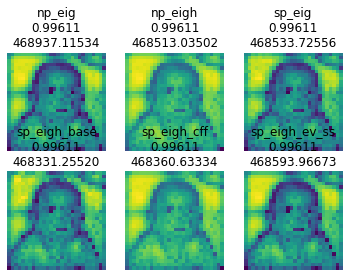

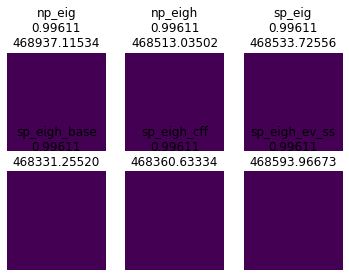

In [58]:
plot_images(output_cut, output_string)

In [49]:
# print(output_cut[0])
print(output_cut[0].min())
print(output_cut[0].max())


# ipyplot.plot_images([]

55.95153628303608
56.44268774703547
